In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.ndimage import gaussian_filter
from PIL import Image
from time import time

%matplotlib inline

random = np.random.default_rng()
np.set_printoptions(precision=2)

plt.rcParams['image.cmap'] = 'gray'

# Using the dataset in a simple autoencoder

In [5]:
class NumpyArrayDataset(Dataset):
    def __init__(self, path, I_0):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
        self.noisy_image_index = \
            {10**2: 1, 10**3: 2, 10**4: 3, 10**5: 4}[I_0]
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
        true_image = 100 * np.reshape(entry[0], (1, *self.img_shape))
        
        noisy_image  = 100 * \
            np.reshape(entry[self.noisy_image_index], (1, *self.img_shape))
    
        # The goal will be for the network to learn the mapping
        # noisy --> true.
        return (true_image.astype(np.single), noisy_image.astype(np.single), idx)
    
    def __len__(self):
        return len(self.npzfile)

# Change these parameters every run

In [6]:
# will be one of 10**2, 10**3, 10**4, 10**5
I_0 = 10**5

# will be one of 0, 0.5, 0.9 for now
alpha = 0.9

In [7]:
path = "shapes-dataset-various-noise-levels.npz"
# I_0 = 10**2

# Load the shapes dataset as a PyTorch Dataset
shapes_dataset = NumpyArrayDataset(path, I_0=I_0)

# Split into test and training set
n = len(shapes_dataset)
train_size = 4 * n // 5
test_size = n - train_size

train_data, test_data = random_split(shapes_dataset, 
                                     [train_size, test_size])

# Construct the DataLoaders
train_loader = DataLoader(train_data, batch_size=64)
test_loader  = DataLoader(test_data,  batch_size=8)

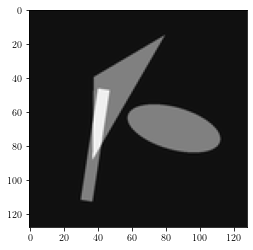

In [8]:
# A nice image with an ellipse, a triangle, and a rectangle. Some of
# the objects overlap, but not all.
illustration_image = shapes_dataset[62][0][0]
plt.imshow(illustration_image)

In [10]:
len(train_data), len(test_data)

(819, 205)

## Verifying all the dimensions

In [11]:
# The dimensions of an element of the train loader are:
# (batch size, channels, image width, image height)
thing = next(iter(train_loader))
print(type(thing))
print(len(thing))
print(type(thing[0]))
print(type(thing[1]))
print(thing[0].shape)
print(thing[1].shape)

<class 'list'>
3
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])


## Training definitions

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=1, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride, padding, bias=False)
        self.relu = nn.LeakyReLU(0.2)
        self.max_pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        return self.max_pool(self.relu(self.conv(x)))        

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels,
                                         kernel_size, stride, padding,
                                         bias=False)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(
#                          self.batch_norm(
                                         self.deconv(x)
#                          )
               )

class DiscriminatorBlock(nn.Module):
    pass

class Reshaper(nn.Module):
    def __init__(self, *shape):
        self.shape = shape
        super(Reshaper, self).__init__()
    def forward(self, x):
        return x.view(self.shape)

In [13]:
def update_discriminator(batch_true, batch_noisy, generator, 
                         discriminator, bce_loss, optimizer_D,
                         should_print=False):    
    optimizer_D.zero_grad()
    
    reconstructions = generator(batch_noisy)
    
    # For both original data and reconstructions, the probability that
    # the data is original according to the discriminator.
    probs_orig = discriminator(batch_true)
    probs_rec  = discriminator(reconstructions.detach())
        
    batch_size = probs_orig.shape[0]
    
    loss1 = bce_loss(probs_orig, 
                     torch.ones((batch_size, 1), 
                                device=batch_true.device))
    
    loss2 = bce_loss(probs_rec, 
                     torch.zeros((batch_size, 1),
                                 device=batch_true.device))
    
    loss = (loss1 + loss2) / 2
    
    if should_print:
        print(probs_orig.cpu().detach().numpy()[:, 0], probs_rec.cpu().detach().numpy()[:, 0], end=" ")
        print(f"{loss1.item():.2f}, {loss2.item():.2f}")
    
#     print(f"Probs orig: {probs_orig.detach().cpu().numpy().flatten()} \
#             probs rec: {probs_rec.detach().cpu().numpy().flatten()} \
#             loss1: {loss1.item():.2f}, loss2: {loss2.item():.2f}")
    
    loss.backward()
    optimizer_D.step()
    
    return loss

def update_generator(batch_true, batch_noisy, generator, discriminator, 
                     mse_loss, bce_loss, optimizer_G, alpha):
    """alpha determines the balance between mse loss and bce loss."""
    batch_size = batch_true.shape[0]
    
    ones = torch.ones((batch_size, 1), device=batch_true.device)
    
    # I'm not sure about this one
    optimizer_D.zero_grad()
    
    optimizer_G.zero_grad()
    
    reconstructions = generator(batch_noisy)
    # This needs to be recomputed, because the parameters for the
    # discriminator were updated just now.
    probs_rec = discriminator(reconstructions)
    
    loss_mse = mse_loss(reconstructions, batch_true)
    loss_bce = bce_loss(probs_rec, ones.reshape(probs_rec.shape))
    
#     print(loss_mse.item(), loss_bce.item())
    
    loss = alpha * loss_bce + (1 - alpha) * loss_mse
    
    loss.backward()
    optimizer_G.step()
    
    return loss_mse, loss_bce

# Training initialization

In [11]:
generator = nn.Sequential(
    EncoderBlock(1, 8, 3, padding=1),
    EncoderBlock(8, 8, 3, padding=1),
    DecoderBlock(8, 8, 2, stride=2),
    DecoderBlock(8, 8, 2, stride=2),
    nn.Conv2d(8, 1, 3, padding=1),
).to(device)

discriminator = nn.Sequential(
    EncoderBlock(1, 8, 3, stride=2, padding=1),
    EncoderBlock(8, 8, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 1),
    nn.Sigmoid()
    # We could also use BCEWithLogitsLoss, and then we would not 
    # need the sigmoid.
).to(device)

# discriminator = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(6, 16, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
#     nn.Linear(1024, 120), nn.ReLU(),
#     nn.Linear(120, 84), nn.ReLU(),
#     nn.Linear(84, 1), nn.Sigmoid()
# ).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.005, 
                         betas=[0.5, 0.999])
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.005, 
                         betas=[0.5, 0.999])
# optimizer_G = optim.SGD(generator.parameters(), lr=0.001)
# optimizer_D = optim.SGD(discriminator.parameters(), lr=0.001)

mse_loss = nn.MSELoss(reduction='sum')
bce_loss = nn.BCELoss(reduction='sum')

for weights in generator.parameters():
    nn.init.normal_(weights, 0, 0.02)
    
# for weights in discriminator.parameters():
#     nn.init.normal_(weights, 0, 0.02)
    
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

discriminator.apply(init_weights);

# Training

In [78]:
%%capture cap --no-stderr

num_epochs = 100
# k = 1
# alpha = 0

start_time = time()

print(f"{'Epoch':^5s}{'G MSE train':^16s}{'G BCE':^16s}{'G train':^16s}{'D BCE':^16s}{'G MSE test':^16s}")
print("=" * 85)

for epoch in range(num_epochs):
    # Tell Torch that we are in training.
    generator.train()
    discriminator.train()
    
    train_loss_d = 0
    train_loss_g_mse = 0
    train_loss_g_bce = 0
    test_loss = 0
    
    # Loop through the dataset
    for batch_true, batch_noisy, idxs in train_loader:
        # Move the data to the GPU
        batch_noisy = batch_noisy.to(device)
        batch_true = batch_true.to(device)
    
#         for i in range(k):
#         if alpha != 0:
        loss_d = \
            update_discriminator(batch_true, batch_noisy, generator, 
                                 discriminator, bce_loss, optimizer_D)
        
        loss_g_mse, loss_g_bce = \
            update_generator(batch_true, batch_noisy, generator, 
                             discriminator, mse_loss, bce_loss, 
                             optimizer_G, alpha)
        
        train_loss_d += loss_d.item()
            
        train_loss_g_mse += loss_g_mse.item()        
        train_loss_g_bce += loss_g_bce.item()
        
    # Calculate the average train loss this epoch
    train_loss_d /= len(train_loader)
        
    train_loss_g_mse /= len(train_data)
    train_loss_g_bce /= len(train_data)
    
    train_loss_g = alpha * train_loss_g_bce + (1 - alpha) * train_loss_g_mse
    
    print(f"{epoch:^5d}{train_loss_g_mse:^16f}{train_loss_g_bce:^16f}{train_loss_g:^16f}{train_loss_d:^16f}", end="")
    
#     if alpha == 0: print(f"Epoch {epoch}, loss: G MSE {train_loss_g_mse:0.6f}, \
# BCE {train_loss_g_bce:0.6f}", end="")
#     if alpha != 0: 
#         print(f"Epoch {epoch}, loss: G MSE {train_loss_g_mse:0.6f}, \
# BCE {train_loss_g_bce:0.6f}, D {train_loss_d:0.6f}", end="")
    
    # Calculate the average test loss this epoch
    generator.eval()
    
    with torch.no_grad():
        for batch_true, batch_noisy, idx in test_loader:
            batch_true = batch_true.to(device)
            batch_noisy = batch_noisy.to(device)
            
            out = generator(batch_noisy)
            test_loss += mse_loss(out, batch_true)
            
    test_loss /= len(test_data)
    print(f"{test_loss:^16f}")
    
    time_per_epoch = (time() - start_time) / (epoch + 1)
    
    print(f'epoch {epoch+1}/{num_epochs}, left: {time_per_epoch * (num_epochs-epoch-1):0.0f}, \
total: {time_per_epoch*num_epochs:0.0f}', end='\r', file=sys.stderr)

In [79]:
with open(f'results-I_0-{I_0}-alpha-{alpha}.txt', 'w') as f:
    f.write(cap.stdout)

## Save the trained model to a file

In [80]:
torch.save(generator.state_dict(), f'trained-model-I_0-{I_0}-alpha-{alpha}.pth')

In [81]:
other_model = nn.Sequential(
    EncoderBlock(1, 8, 3, padding=1),
    EncoderBlock(8, 8, 3, padding=1),
    DecoderBlock(8, 8, 2, stride=2),
    DecoderBlock(8, 8, 2, stride=2),
    nn.Conv2d(8, 1, 3, padding=1),
).to(device)
other_model.load_state_dict(torch.load(f'trained-model-I_0-{I_0}-alpha-{alpha}.pth'))

<All keys matched successfully>

/tmp/ipykernel_31274/3868308891.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


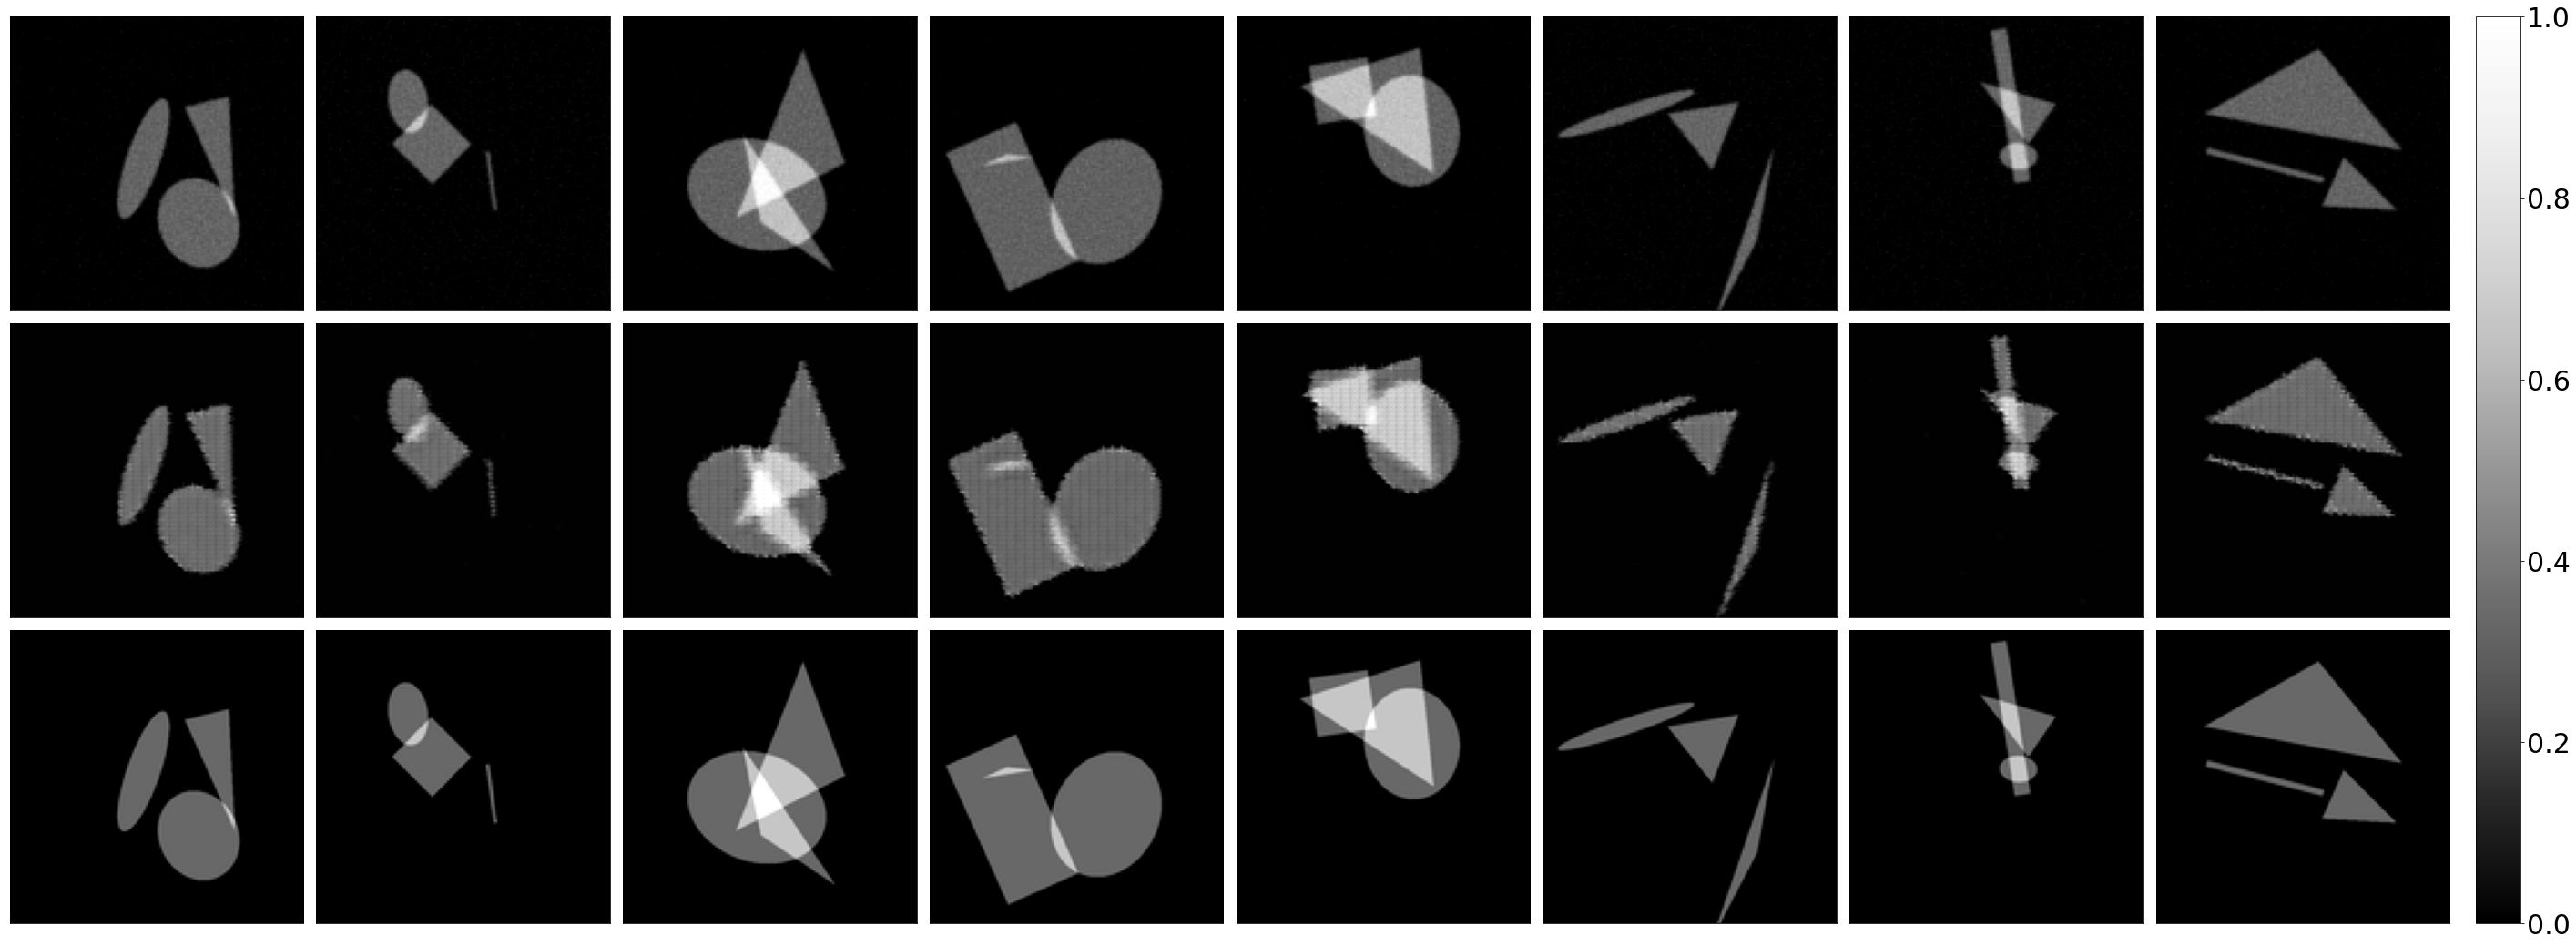

In [82]:
other_model.to(device)

with torch.no_grad():
    for batch_true, batch_noisy, idxs in test_loader:
        model_output = other_model(batch_noisy.to(device))
        show_batches(batch_noisy, model_output.cpu(), batch_true)
        break

# You probably don't want to run this

...or do you?

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Tell Torch that we are in training.
    discriminator.train()
    
    train_loss_d = 0
    # Loop through the dataset
    for batch_num, (batch_true, batch_noisy, idxs) in enumerate(train_loader):
        # Move the data to the GPU
        batch_noisy = batch_noisy.to(device)
        batch_true = batch_true.to(device)
    
        loss_d = \
            update_discriminator(batch_true, batch_noisy, generator, 
                                 discriminator, bce_loss, optimizer_D,
                                 should_print=False)     
        
        train_loss_d += loss_d.item()
        
    # Calculate the average train loss this epoch
    train_loss_d /= len(train_loader)
    print(f"Epoch {epoch}, loss: D {train_loss_d:0.6f}")

Epoch 0, loss: D 22.534634
Epoch 1, loss: D 14.687257
Epoch 2, loss: D 9.080849
Epoch 3, loss: D 5.143399
Epoch 4, loss: D 2.698327
Epoch 5, loss: D 1.490614
Epoch 6, loss: D 0.920259
Epoch 7, loss: D 0.618537


In [28]:
with torch.no_grad():
    for batch_true, batch_noisy, idxs in test_loader:
        batch_true = batch_true.to(device)
        batch_noisy = batch_noisy.to(device)
        
        batch_size = batch_true.shape[0]
        
        ones  = torch.ones((batch_size,), device=batch_true.device)
        zeros = torch.zeros((batch_size,), device=batch_true.device)
        
        probs_rec = discriminator(generator(batch_noisy))
#         print(bce_loss(probs_rec, zeros.reshape(probs_rec.shape)))
               
        probs_orig = discriminator(batch_true)        
#         print(bce_loss(probs_orig, ones.reshape(probs_orig.shape)))
#         print(bce_loss(probs_rec, ones.reshape(probs_orig.shape)))
        
        
        print(probs_rec)
        print(probs_orig)
        
#         print(probs_rec, zeros, ones)

tensor([[8.4129e-07],
        [1.1943e-06],
        [3.6878e-06],
        [2.2766e-07],
        [3.9809e-05],
        [2.7960e-06],
        [3.7227e-06],
        [2.1064e-06]], device='cuda:0')
tensor([[0.9998],
        [0.9942],
        [0.9997],
        [0.9965],
        [0.9995],
        [0.9999],
        [0.9999],
        [1.0000]], device='cuda:0')
tensor([[9.5757e-07],
        [6.2703e-05],
        [2.1343e-05],
        [2.3174e-06],
        [4.4015e-06],
        [3.6932e-05],
        [2.6226e-04],
        [4.7558e-05]], device='cuda:0')
tensor([[0.9999],
        [0.9990],
        [1.0000],
        [0.9955],
        [0.9974],
        [0.9577],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[2.1521e-06],
        [1.2039e-06],
        [1.0461e-06],
        [1.5896e-07],
        [1.1501e-06],
        [1.8760e-06],
        [7.5324e-06],
        [2.9902e-06]], device='cuda:0')
tensor([[0.9999],
        [0.9999],
        [0.9970],
        [1.0000],
        [0.9986],
    

## Visualise the results of the network

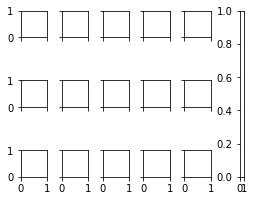

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(4., 4.))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(3, 5),
                 axes_pad=(0.2, 0.6),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.4,
                )

In [13]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_batches(*args):
    """It is assumed that all tensors contain an equal number of
    images."""
    batch_tensors = args
    
    # Assert that we are working with a grayscale iamge
    assert all(tensor.shape[1] == 1 for tensor in batch_tensors)
    
    num_batches = len(batch_tensors)
    num_images = batch_tensors[0].shape[0]

    plt.rcParams.update({'font.size': 30})
    
    fig = plt.figure(figsize=(5 * num_images, 5 * num_batches))
    
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(num_batches, num_images),
                 axes_pad=(0.2, 0.2),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.4,
                 )
    
#     fig, axs = plt.subplots(num_batches, num_images, 
#                             figsize=(5 * num_images, 5 * num_batches)) 
    
    for i in range(num_batches):
        vmin = 0
        vmax = 1
        
        for j in range(num_images):
            ax = grid[num_images * i + j]
            
            
            pic = ax.imshow(batch_tensors[i][j, 0], 
                                   vmin=vmin, vmax=vmax, 
                                   cmap=plt.cm.Greys_r)
            
            ax.set_xticks([])
            ax.set_yticks([])
            
    ax.cax.colorbar(pic)
    ax.cax.toggle_label(True)
#     plt.colorbar(pic)

    plt.tight_layout()

#     for i in range(num_batches):
#         bbox_ax = axs[0,1].get_position()
    
#         vmin = -2 if i == 0 else 0
#         vmax = 2 if i == 0 else 1
        
#         cbar_ax = fig.add_axes([1.01, bbox_ax.y0, 0.02, bbox_ax.y1-bbox_ax.y0])
#         cbar_im1a = plt.colorbar(pic, cax=cbar_im1a_ax)

0.06776631
0.055153448
0.06301076
0.062468346
0.0703077


/tmp/ipykernel_30167/1543298203.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


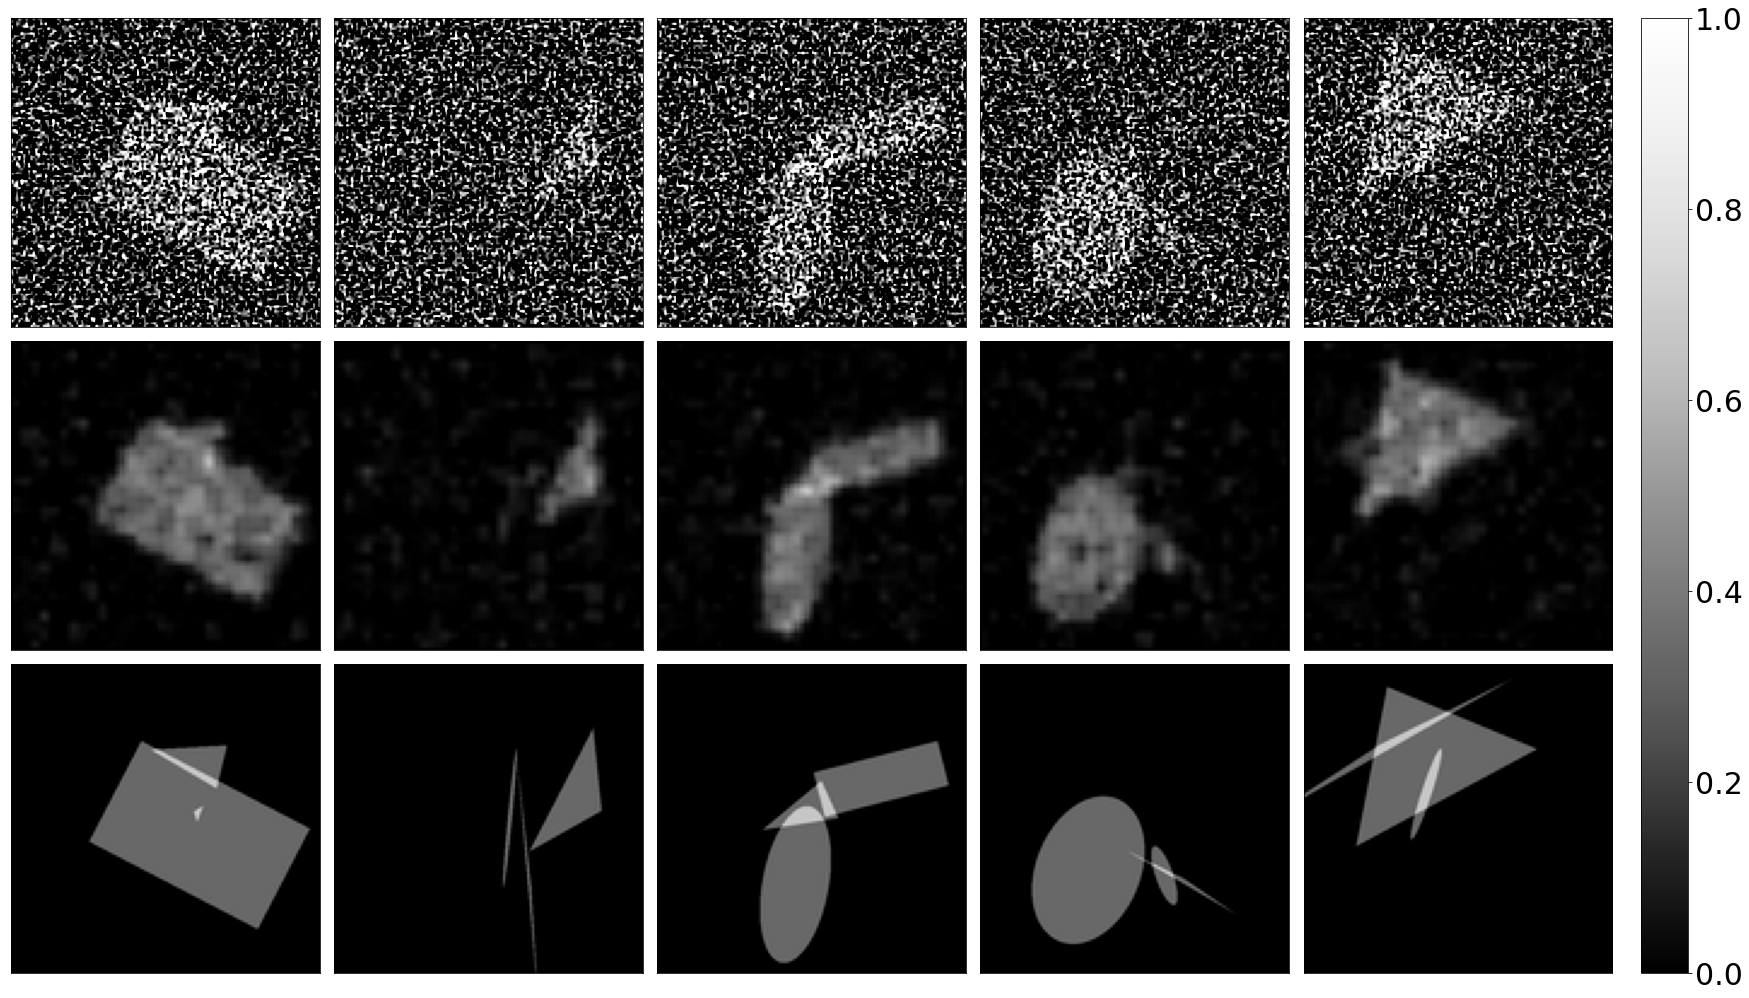

In [69]:
with torch.no_grad():
    for batch_true, batch_noisy, idxs in test_loader:
        model_output = generator(batch_noisy.to(device))
        batch_true = batch_true[:5]
        batch_noisy = batch_noisy[:5]
        
        for i in range(batch_true.shape[0]):
            img_orig = batch_true[i, 0] / 100
            img_rec = model_output[i, 0] / 100
            
            print(np.linalg.norm(img_orig - img_rec.cpu()))
        
        show_batches(batch_noisy, model_output.cpu(), batch_true)
        break

# Making plots for various levels of noise

/tmp/ipykernel_12629/3205084998.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


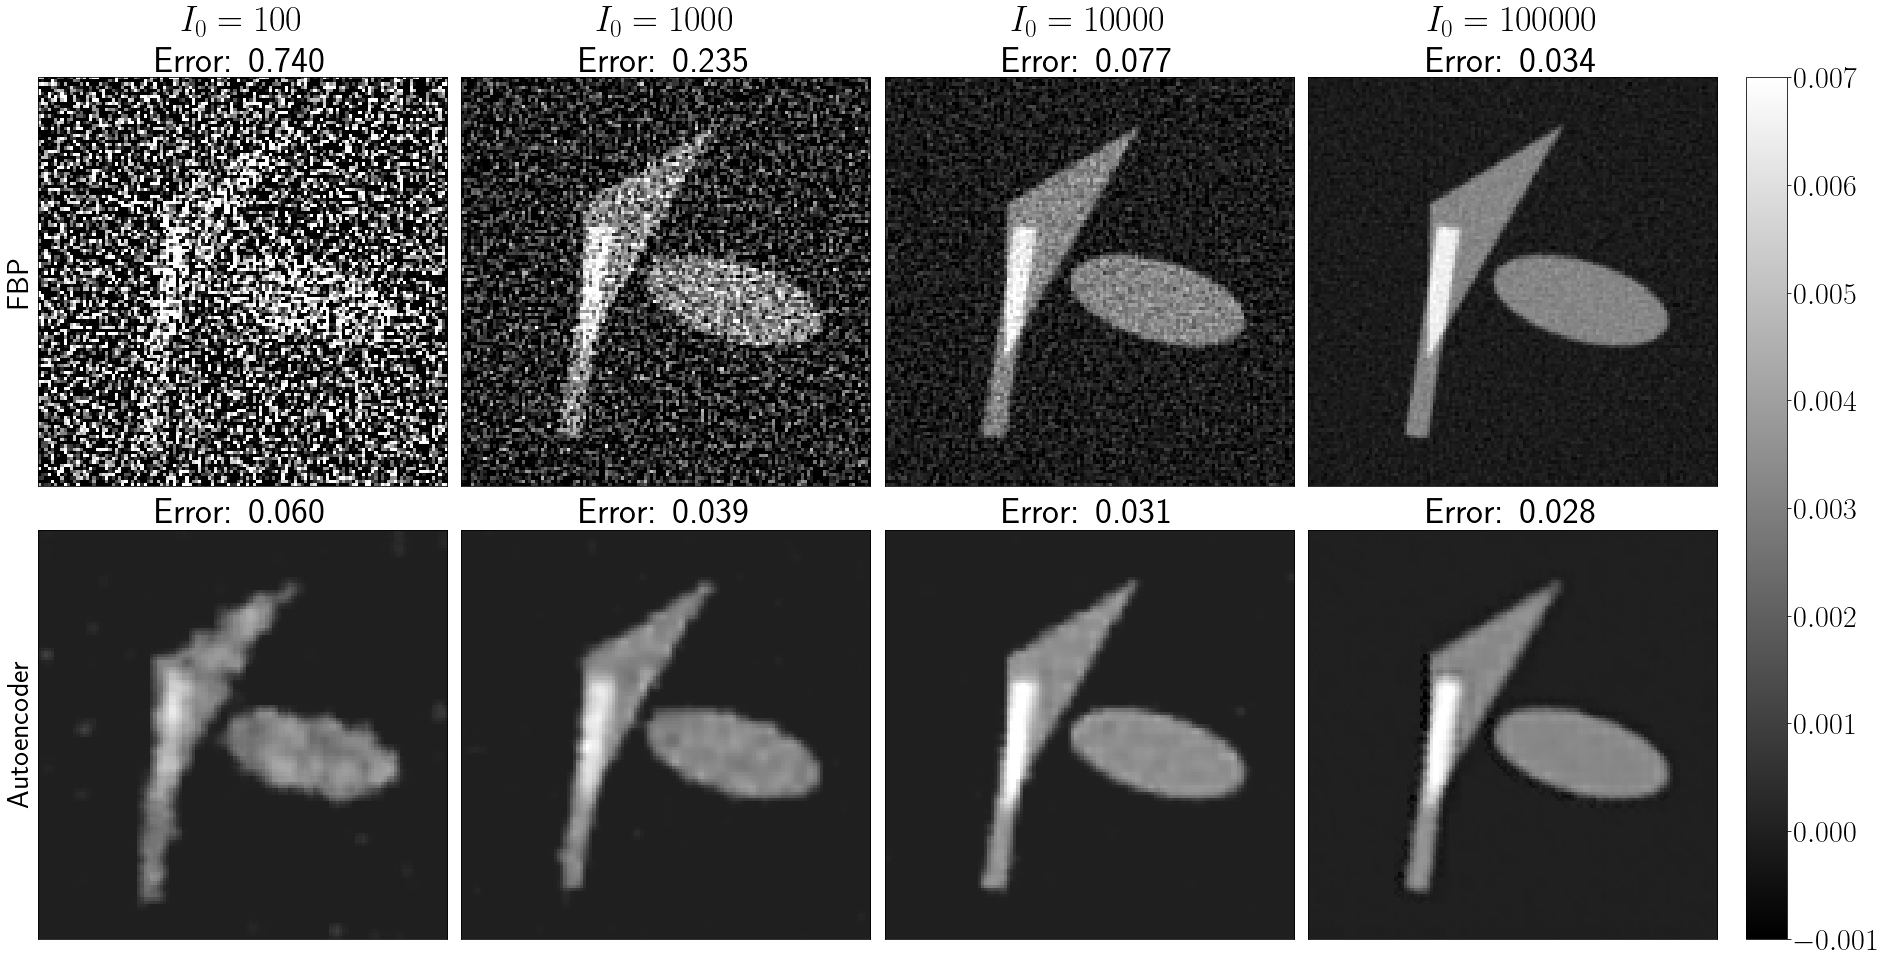

In [50]:
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"text.usetex": True, "font.size": 24})

illustration_image = torch.tensor(shapes_dataset[62][1].reshape(1, 1, 128, 128))

other_model = nn.Sequential(
    EncoderBlock(1, 8, 3, padding=1),
    EncoderBlock(8, 8, 3, padding=1),
    DecoderBlock(8, 8, 2, stride=2),
    DecoderBlock(8, 8, 2, stride=2),
    nn.Conv2d(8, 1, 3, padding=1),
).to(device)

alpha = 0

plt.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(28, 14))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,4),
                 axes_pad=(0.2, 0.6),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.4,
                 )

vmin, vmax = -0.001, 0.007

for i, I_0, ax0, ax1 in zip(
        [0, 8, 16, 24], [10**2, 10**3, 10**4, 10**5], grid[:4], grid[4:]):
    shapes_dataset = NumpyArrayDataset(path, I_0=I_0)
    
    true_image = shapes_dataset[62][0][0]
    noisy_image = shapes_dataset[62][1][0]
    
    ax0.imshow(noisy_image / 100, vmin=vmin, vmax=vmax)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title(f"Error: {np.linalg.norm(true_image - noisy_image) / 100:.3f}")
    
    if i == 0: ax0.set_ylabel('FBP')
        
    ax0.annotate(f"$I_0 = {I_0:0.0f}$", xy=(0.5, 1.1), xytext=(0, 5),
             xycoords='axes fraction', textcoords='offset points',
             size='large', ha='center', va='baseline')
    
    pic = torch.tensor(noisy_image.reshape(1, 1, 128, 128))
    
    other_model.load_state_dict(torch.load(f'trained-model-I_0-{I_0}-alpha-{alpha}.pth'))
    other_model.to(device)
    
    with torch.no_grad():
        reconstruction = other_model(pic.to(device)).cpu().view(128, 128)
        
        pltimg = ax1.imshow(reconstruction / 100, vmin=vmin, vmax=vmax)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title(f"Error: {np.linalg.norm(reconstruction - true_image) / 100:0.3f}")
        
        if i == 0: ax1.set_ylabel('Autoencoder')
                    
ax0.cax.colorbar(pltimg)
ax0.cax.toggle_label(True)
plt.tight_layout()

plt.savefig('fbp-and-autoencoder-reconstructions.png')

/tmp/ipykernel_28681/617969349.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


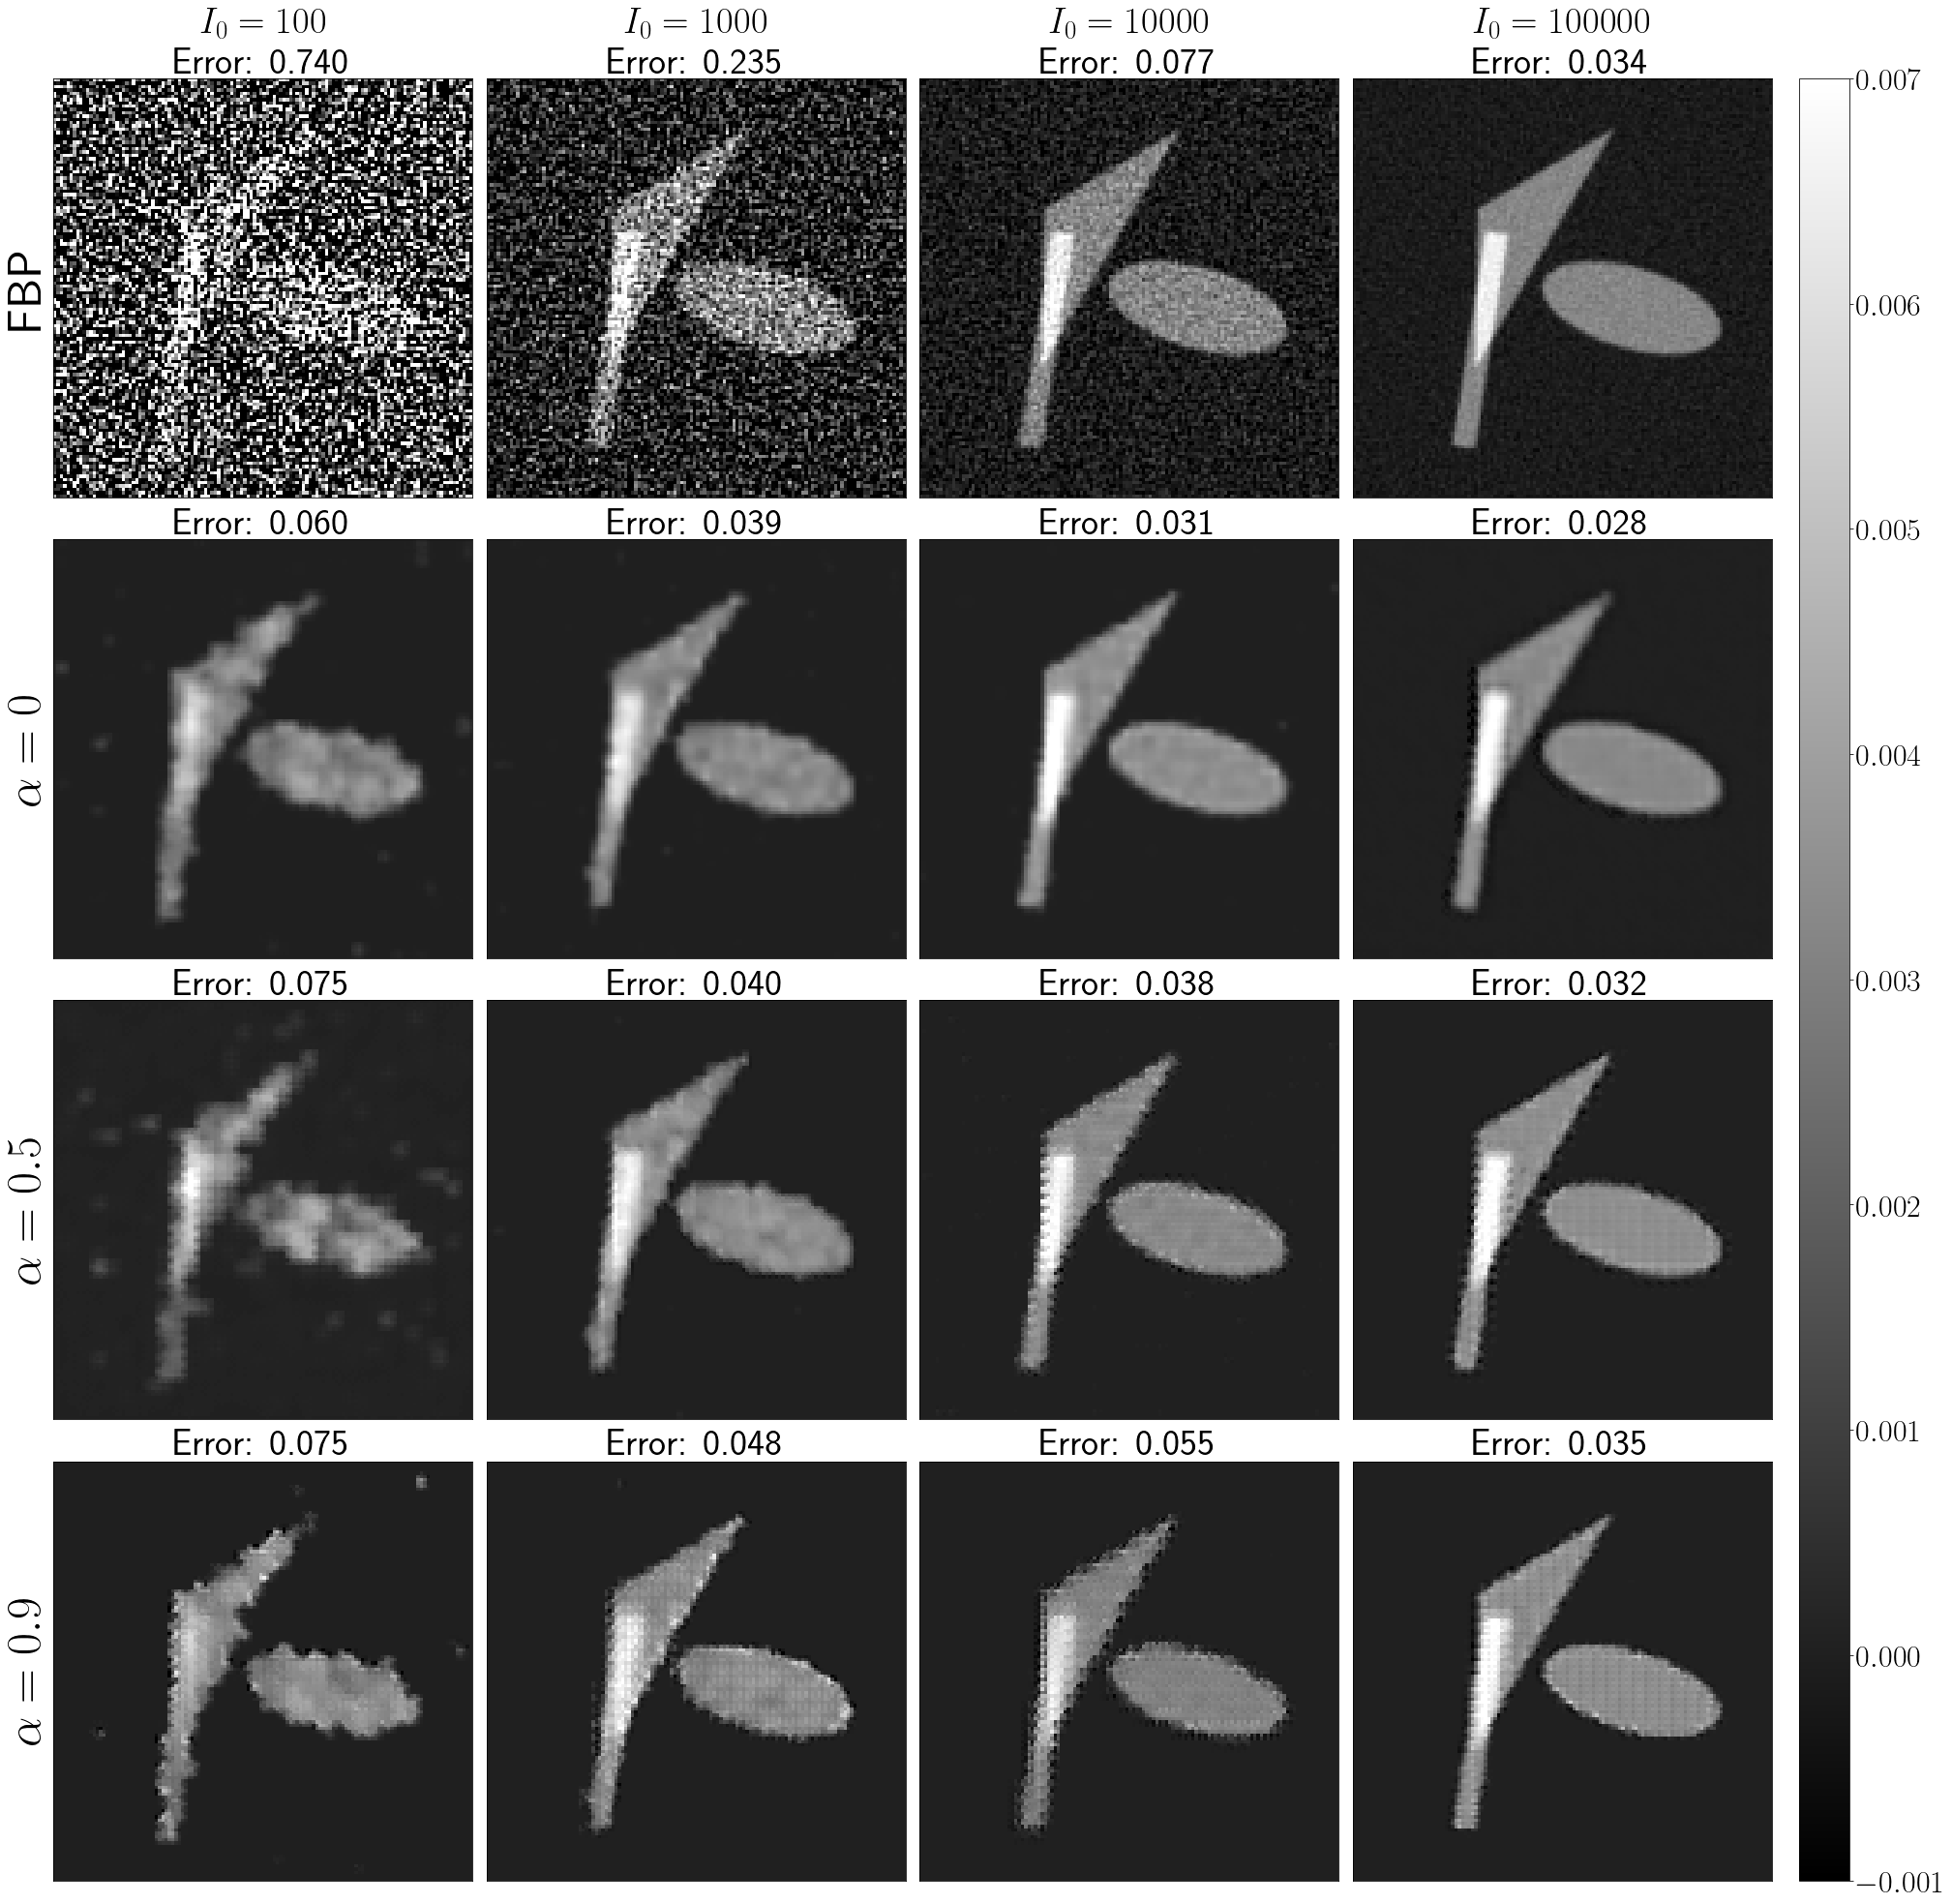

In [29]:
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({"text.usetex": True, "font.size": 32})
plt.rc('axes', labelsize=50)

illustration_image = torch.tensor(shapes_dataset[62][1].reshape(1, 1, 128, 128))

other_model = nn.Sequential(
    EncoderBlock(1, 8, 3, padding=1),
    EncoderBlock(8, 8, 3, padding=1),
    DecoderBlock(8, 8, 2, stride=2),
    DecoderBlock(8, 8, 2, stride=2),
    nn.Conv2d(8, 1, 3, padding=1),
).to(device)

fig = plt.figure(figsize=(28, 28))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(4, 4),
                 axes_pad=(0.2, 0.6),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="3%",
                 cbar_pad=0.4,
                 )

vmin, vmax = -0.001, 0.007

with torch.no_grad():
    for i, I_0 in enumerate([10**2, 10**3, 10**4, 10**5]):
        shapes_dataset = NumpyArrayDataset(path, I_0=I_0)

        true_image = shapes_dataset[62][0][0]
        noisy_image = shapes_dataset[62][1][0]
        grid[i].imshow(noisy_image / 100, vmin=vmin, vmax=vmax)
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        grid[i].set_title(f"Error: {np.linalg.norm(true_image - noisy_image) / 100:.3f}")
        
        grid[i].annotate(f"$I_0 = {I_0:0.0f}$", xy=(0.5, 1.1), xytext=(0, 5),
             xycoords='axes fraction', textcoords='offset points',
             size='large', ha='center', va='baseline')

        for j, alpha in enumerate([0, 0.5, 0.9]):
            ax = grid[4 * (j + 1) + i]
            pic = torch.tensor(noisy_image.reshape(1, 1, 128, 128))
            
            other_model.load_state_dict(torch.load(f'trained-model-I_0-{I_0}-alpha-{alpha}.pth'))
            other_model.to(device)
            
            reconstruction = other_model(pic.to(device)).cpu().view(128, 128)
        
            pltimg = ax.imshow(reconstruction / 100, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Error: {np.linalg.norm(reconstruction - true_image) / 100:0.3f}")
        
grid[0].set_ylabel('FBP')
        
for j, alpha in enumerate([0, 0.5, 0.9]):
    grid[4 * (j + 1)].set_ylabel(f'$\\alpha = {alpha}$')
        
ax.cax.colorbar(pltimg)
ax.cax.toggle_label(True)
plt.tight_layout()

plt.savefig('fbp-and-autoencoder-reconstructions-all.png')

# Plotting the results of a run over time

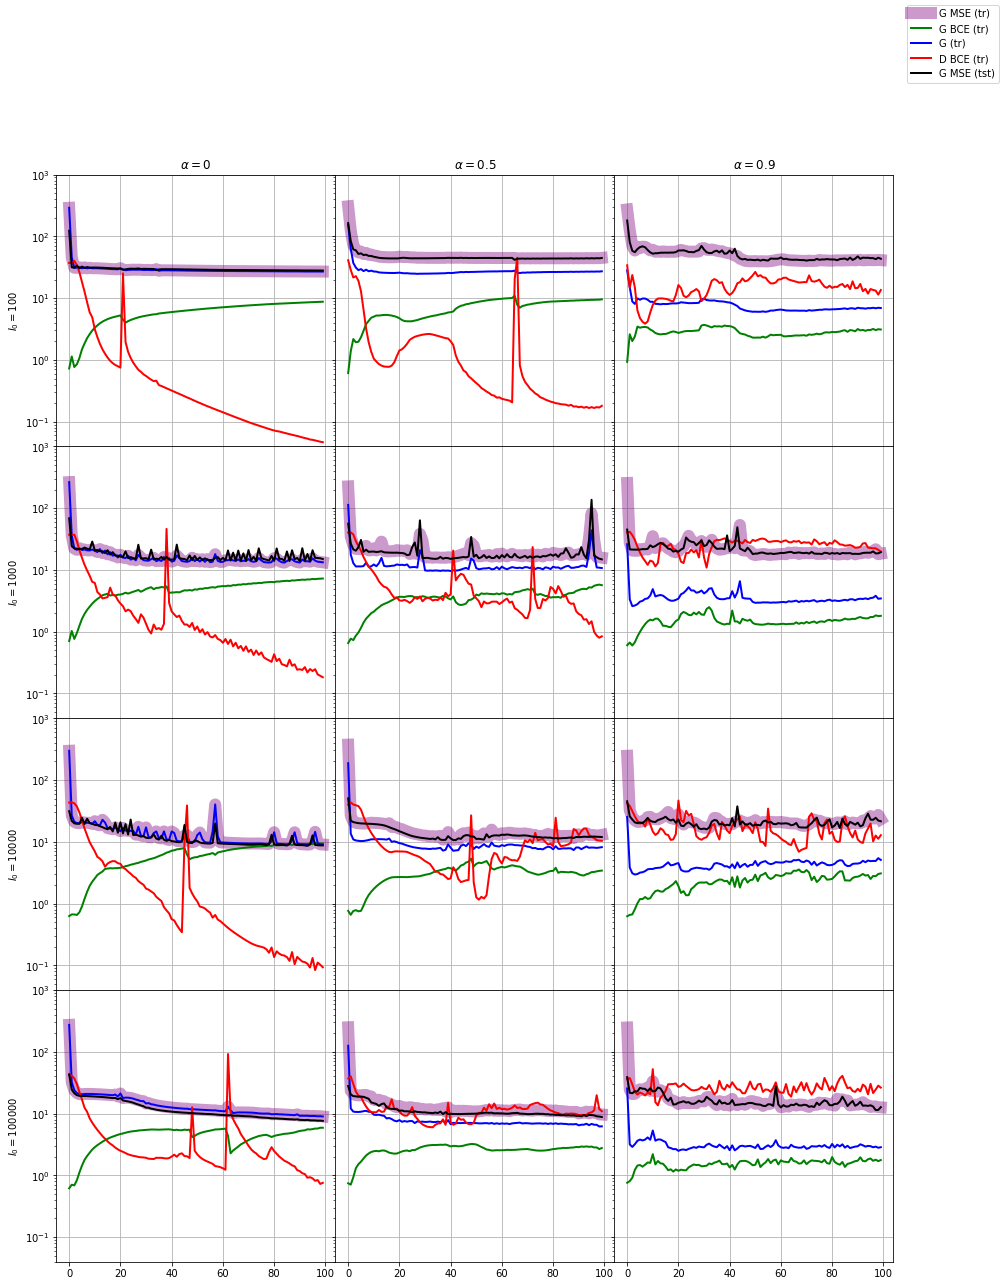

In [50]:
alphas = [0, 0.5, 0.9]
I_0_list = [10**2, 10**3, 10**4, 10**5]

fig, axs = plt.subplots(4, 3, figsize=(15, 20))

num_losses = 5
num_epochs = 100

loss_names = ['G MSE (tr)', 'G BCE (tr)', 'G (tr)', 'D BCE (tr)', 'G MSE (tst)']
styles = ['solid', 'solid', 'solid', 'solid', 'solid']
colors = ['purple', 'green', 'blue', 'red', 'black']
widths = [12, 2, 2, 2, 2]
opacs = [0.4, 1, 1, 1, 1]

for i, alpha in enumerate(alphas):
    for j, I_0 in enumerate(I_0_list):
        results_file = f'results-I_0-{I_0}-alpha-{alpha}.txt'

        #print(f"{epoch:^5d}{train_loss_g_mse:^16f}{train_loss_g_bce:^16f}{train_loss_g:^16f}{train_loss_d:^16f}", end="")

        # There are 5 different types of losses

        losses = np.zeros((num_losses, num_epochs), dtype=float)

        with open(results_file, 'r') as f:
            # Skip the first two lines
            for _ in range(2):
                next(f)

            for k, line in enumerate(f):
                line = line.split()

                for l in range(num_losses):
                     losses[l, k] = float(line[l + 1])

        for l in range(num_losses):
            axs[j, i].plot(losses.T[:, l], ls=styles[l], c=colors[l], lw=widths[l], alpha=opacs[l])
                
        axs[j, i].set_yscale('log')
        if j != len(I_0_list) - 1: axs[j, i].set_xticklabels([])
        if i != 0: axs[j, i].set_yticklabels([])
        axs[j, i].grid()
        axs[j, i].set_ylim(10**(-1.4), 10**3)

for i, alpha in enumerate(alphas):
    axs[0, i].set_title(f'$\\alpha = {alpha}$')
    
for j, I_0 in enumerate(I_0_list):
    axs[j, 0].set_ylabel(f'$I_0 = {I_0}$')
        
fig.legend(labels=loss_names)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('nn-training-runs.png')

# Calculating the final error norms for each network

In [38]:
alpha = 0
I_0 = 10**5

error_norms = 0

with torch.no_grad():    
    for true_image, noisy_image, idx in shapes_dataset:
        reconstruction = noisy_image
        reconstruction /= 100
        true_image /= 100
        error_norm = np.linalg.norm(reconstruction - true_image)
        error_norms += error_norm
        
print(error_norms / len(shapes_dataset)) 

0.035162955142368446


In [40]:
alpha = 0
I_0 = 10**5

error_norms = 0

with torch.no_grad():
    other_model.load_state_dict(torch.load(f'trained-model-I_0-{I_0}-alpha-{alpha}.pth'))
    other_model.to(device)
    
    for true_image, noisy_image, idx in shapes_dataset:
        noisy_image = torch.tensor(noisy_image.reshape(1, 1, 128, 128)).to(device)
        reconstruction = other_model(noisy_image)
        
        reconstruction /= 100
        true_image /= 100
        error_norm = np.linalg.norm(reconstruction.cpu().view(128, 128) - true_image)
        error_norms += error_norm
        
print(error_norms / len(shapes_dataset)) 

0.027483010163450672


# The big library of old code
## Dimension checking code

In [14]:
X = torch.rand(size=(1, 1, 128, 128), dtype=torch.float32).to(device)

for layer in generator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)
    
X = torch.rand(size=(1, 1, 128, 128), dtype=torch.float32).to(device)

for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

EncoderBlock output shape: 	 torch.Size([1, 8, 64, 64])
EncoderBlock output shape: 	 torch.Size([1, 8, 32, 32])
DecoderBlock output shape: 	 torch.Size([1, 8, 64, 64])
DecoderBlock output shape: 	 torch.Size([1, 8, 128, 128])
Conv2d output shape: 	 torch.Size([1, 1, 128, 128])
EncoderBlock output shape: 	 torch.Size([1, 8, 32, 32])
EncoderBlock output shape: 	 torch.Size([1, 8, 8, 8])
Flatten output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


## Old generator code

In [ ]:
# NOTE: this is a toy model taken from the internet to test the combination
# of the shape dataset + autoencoder + lisa. The final model will have many
# architectural changes, we still need to implement GAN loss for instance,
# and flatten the data in the middle as is usual in convolutional
# autoencoders.
# Source: https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
       
#         self.relu = nn.ReLU()
#         self.max_pool = nn.MaxPool2d(2)
#         self.linear = nn.Linear(128 * 128, 128 * 128)
        
#         #Encoder
#         self.conv1 = nn.Conv2d(1,  8,  3, padding=1)  
#         self.conv2 = nn.Conv2d(8,  16, 3, padding=1)
#         self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        
       
#         #Decoder
#         self.deconv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.relu(self.conv3(x))
#         x = x.view((-1, 4096, 4096))
#         x = self.linear(4096, 4096),
#         x = x.view((-1, 16, 16, 16))
#         x = self.deconv1(x)
#         x = self.deconv2(x)
              
#         return x
# generator = nn.Sequential(    
#     nn.Conv2d(1,  16,  3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(16,  4, 3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(2),
# #     nn.Conv2d(8, 8, 3, padding=1), nn.ReLU(),
# #     nn.MaxPool2d(2),
# #     nn.Flatten(),
# #     nn.Linear(2048, 2048),
# #     Reshaper(-1, 8, 16, 16),
#     nn.ConvTranspose2d(4, 16, 2, stride=2), nn.ReLU(),
#     nn.ConvTranspose2d(16, 1, 2, stride=2), nn.Sigmoid()
# #     nn.ConvTranspose2d(8, 1, 2, stride=2)
# ).to(device)

# generator = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(in_channels=8, 16, 3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(16, 16, 3, padding=1),
#     nn.MaxPool2d(2),
#     nn.Flatten(),
#     nn.Linear(4096, 4096),
    
    
# )
    
# model = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
# #     nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
# #     nn.Linear(120, 84), nn.Sigmoid(),
# #     nn.Linear(84, 10)
# ).to(device)

## Old training code

In [ ]:
# epochs = 100

# for epoch in range(epochs):
#     loss = 0
#     for batch_true, batch_noisy in train_loader:
#         # reshape mini-batch data to [N, 784] matrix
#         # load it to the active device
#         batch_noisy = batch_noisy.to(device)
#         batch_true = batch_true.to(device)
        
#         # reset the gradients back to zero
#         # PyTorch accumulates gradients on subsequent backward passes
#         optimizer.zero_grad()
        
#         # compute reconstructions
#         outputs = model(batch_noisy.float())
        
#         # compute training reconstruction loss
#         train_loss = criterion(outputs, batch_true)
        
#         # compute accumulated gradients
#         train_loss.backward()
        
#         # perform parameter update based on current gradients
#         optimizer.step()
        
#         # add the mini-batch training loss to epoch loss
#         loss += train_loss.item()
    
#     # compute the epoch training loss
#     loss = loss / len(train_loader)
    
#     # display the epoch training loss
#     if epoch % 5 == 0:
#         print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))